In [8]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from unet import UNet


%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_mask_pairs = []
        self.transform = transform

        # Loop through all patient folders
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Collect image–mask pairs
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    image_path = os.path.join(patient_path, file)
                    mask_path = image_path.replace(".tif", "_mask.tif")
                    if os.path.exists(mask_path):
                        self.image_mask_pairs.append((image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask

        return image, mask

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

# print("Path to dataset files:", path)

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_root = r"data/kaggle_3m"  # Update this path to your dataset location
dataset = BrainMRIDataset(root_dir=dataset_root, transform=transform)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
val_size=  0.2
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
train_idx, val_idx = indices[split: ], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size= 32 , sampler=train_sampler)
val_loader = DataLoader(dataset,batch_size=32 ,sampler=val_sampler)

images.shape =torch.Size([32, 3, 256, 256])


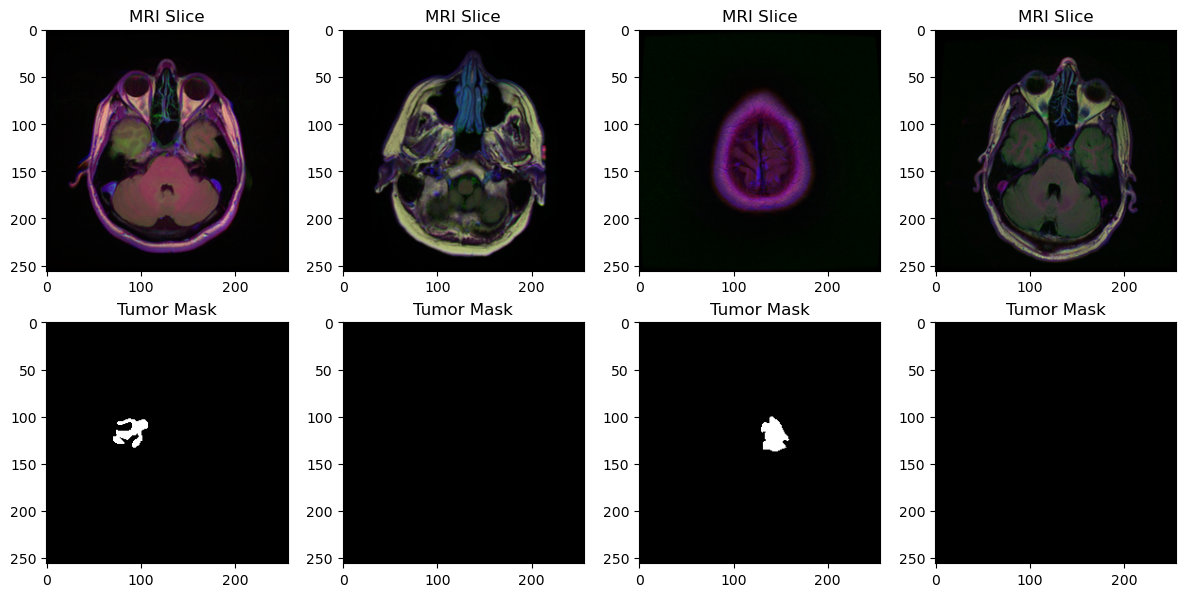

In [6]:
images, masks = next(iter(train_loader))
print(F"{images.shape =}")
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("MRI Slice")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i][0], cmap='gray')
    plt.title("Tumor Mask")

plt.tight_layout()
plt.show()

In [12]:
model = UNet(img_channels=3, num_classes=1).to(device)

lr= 3e-4
batch = 8
epochs = 100

In [13]:

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
crterion = nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(epochs):
    model.train()
    runing_loss = 0
    for idx , (image,mask) in enumerate(train_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)
        
        out = model(image)
        optimizer.zero_grad()
        loss = crterion(out, mask)
        runing_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = runing_loss / idx + 1 
    model.eval()
    val_loss_runinig= 0
    with torch.no_grad() :  # for fast compution
        for idx , (image, mask) in enumerate(val_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)
            out = model(image)
            loss =crterion(out, mask)
            val_loss_runinig += loss.item()
        val_loss = val_loss_runinig / idx + 1 
        print(f"Epoch : {epoch + 1} ... Train Loss:{train_loss : .4f}....Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), "segment2.pth")